In [16]:
import pandas as pd
import numpy as np
import scipy
from scipy import io
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import glob
import random

from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.time import Time
from astropy import units as u
import scipy.integrate as integrate
import lightkurve

from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

import math
import datetime as dt
import lightkurve.io as l
from lightkurve.io.generic import read_generic_lightcurve

In [17]:
def clean_text(str):
    s = result = ''.join([i for i in archivo[20:] if not i.isdigit()])
    t = s.replace('_curves.txt', '')
    u = t.replace('+', '')
    u = u.replace('-', '')
    if 'KsJs' in u:
        u = u.replace('KsJs', 'Ks Js')
    if u[0] == '_':
        u = u[1:]
    if 'AB' in u:
        u = u.replace('AB', '')
    return u

In [18]:
# Function is created in order to eliminate characters which are not Printable ASCII characters that appear 
# from the data transfer from repository
def textcleaner(str1):
    w = str(str1).split('\n')[0]
    x = str(w)
    y = str(x.split('  ')[2])
    z = y.replace("'", "")
    if z == '-11.62963800\xa0':
        return z[:12]
    else:
        return z

In [19]:
# Function is created in order to eliminate characters which are not Printable ASCII characters that appear 
# from the data transfer from repository
def numcleaner(str1):
    w = str(str1).split('\n')[0]
    x = str(w)
    x.split('  ')
    if ' NaN' in x:
        y = str(x.split('  ')[1])
        z = y.replace("'", "")
        a = z.replace(" ", "")
        return a
    else:
        w = str(str1).split('\n')[0]
        x = str(w)
        y = str(x.split('  ')[2])
        z = y.replace("'", "")
        return z

In [20]:
#repository like the one we have online
general_data = pd.read_csv('/Users/kmanj/FITS_BD_Files/Repository_Data/Liu_Repo.csv', encoding ='latin1')

In [21]:
dir = '/Users/kmanj/Manjavacas Research/Liu_2024/Liu2024/non-variables/'
dir_save = '/Users/kmanj/FITS_BD_Files/Data/Liu_2024/NV/'

In [22]:
dwarfs_files = os.listdir(dir)
dwarf_dat = [archive for archive in dwarfs_files if archive.endswith(".txt")]
dwarf_dat;

In [23]:
new_name_file = []
new_name = []
date_obs = []
band_obs = []

for archivo in dwarf_dat:
    band_obs.append(clean_text(archivo))
    
for archivo in dwarf_dat:
    date_obs.append(archivo[0:10])

# Iterate over the elements of the first list.
for archivo in dwarf_dat:
    if 'W' in archivo:
        if 'WISE' in archivo:
            first_5_characteres = archivo[15:20]
        else:
            first_5_characteres = 'J' + archivo[12:16]
    # Extract the first 5 characters of the file name
    elif '2M' in archivo:
        if '2MASS' in archivo:
            first_5_characteres = archivo[16:21]
        else:
            first_5_characteres = 'J' + archivo[13:17]
    elif 'SDSS' in archivo:
        if 'SDSSJ' in archivo:
            first_5_characteres = archivo[15:20]
        else:
            first_5_characteres = 'J' + archivo[15:19]
    elif 'PSO' in archivo:
        first_5_characteres = 'J1112'
    else:
        first_5_characteres = archivo[11:16]
    
    # Iterate over the elements of the second list.
    for valor in general_data['Name_file']:
        # Extract the first 5 characters of the reference value
        valor = str(valor)
        first_5_values = valor[:5]
        
        # Compare the first 5 characters of the two elements
        if first_5_characteres == first_5_values:
            # Modify the file name to the desired format
            nuevo_nombre = valor + ".dat"
            # Add the new name to the new list
            new_name.append(valor)
            new_name_file.append(nuevo_nombre)
            # Break the inner loop once a match is found.
            break

            
new_name_file;
new_name;
date_obs;
len(new_name)

45

In [24]:
#lecture of the data
dwarfs_data = []
for i in range(len(new_name_file)):
    data = pd.read_csv("{}{}".format(dir,dwarf_dat[i]), comment='#', header=None, sep=' ')
    dwarfs_data.append(data)
    

In [25]:
dwarfs_data;

In [26]:
Reference = 'Liu et. al 2024, RAS, 527, 3'
Telescope = 'New Technology Telescope'
Instrument = 'Son of Isaac (SOFI)'
TSTART = 59508.036876
TSTOP = 59512.157403

In [27]:
Object = []
SpectralType = []
Jmag = []
Hmag = []
Kmag = []
dJmag = []
dHmag = []
dKmag = []
RA = []
Dec = []



for i in range(len(new_name_file)): 
    Object.append(textcleaner(general_data['Name'][general_data['Name_file'] == new_name[i]]))
    SpectralType.append(textcleaner(general_data['SpT '][general_data['Name_file'] == new_name[i]]))
    Jmag.append(numcleaner(general_data['J'][general_data['Name_file'] == new_name[i]]))
    dJmag.append(numcleaner(general_data['dJ'][general_data['Name_file'] == new_name[i]]))
    Hmag.append(numcleaner(general_data['H'][general_data['Name_file'] == new_name[i]]))
    dHmag.append(numcleaner(general_data['dH'][general_data['Name_file'] == new_name[i]]))
    Kmag.append(numcleaner(general_data['K'][general_data['Name_file'] == new_name[i]]))
    dKmag.append(numcleaner(general_data['dK'][general_data['Name_file'] == new_name[i]]))
    RA.append(textcleaner(general_data['RA'][general_data['Name_file'] == new_name[i]]))
    Dec.append(textcleaner(general_data['DEC'][general_data['Name_file'] == new_name[i]]))
Object;

In [28]:
name_files = []
for i in range(len(dwarfs_data)):
    lc = l.LightCurve(time = list(dwarfs_data[i][0]), flux = list(dwarfs_data[i][1]) * u.dimensionless_unscaled, flux_err = list(dwarfs_data[i][2]) * u.dimensionless_unscaled)
    name = dir_save + Object[i]
    contador = 1
    while name + '_Liu2024.fits' in name_files:
        name = name + '_' + str(contador)
        contador += 1
    else:
        lc.to_fits(path = name + '_Liu2024.fits')
        name_files.append(name + '_Liu2024.fits')

In [29]:
for i in range(len(dwarf_dat)):
    with fits.open(name_files[i], mode = 'update') as f:
        f[0].header['OBJECT'] = Object[i]
        f[0].header['SPECTYPE'] = SpectralType[i]
        f[0].header['TSTART'] = TSTART
        f[0].header['TSTOP'] = TSTOP
        f[0].header['DATE_OBS'] = date_obs[i]
        f[0].header['TIMESYS'] = 'mjd'
        f[0].header['TELESCOP'] = Telescope
        f[0].header['INSTRUME'] = Instrument
        f[0].header['FILTER'] = band_obs[i]
        f[0].header['VOREF'] = Reference
        f[0].header['RA_OBJ'] = RA[i]
        f[0].header['DEC_OBJ'] = Dec[i]
        f[0].header['JMAG'] = Jmag[i] + '+/-' + dJmag[i]
        f[0].header['HMAG'] = Hmag[i] + '+/-' + dHmag[i]
        f[0].header['KMAG'] = Kmag[i] + '+/-' + dKmag[i]
        f[1].header['TUNIT1'] = 'Hrs'

C:\Users\kmanj\anaconda3\lib\site-packages\lightkurve\lightcurve.py:1954: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


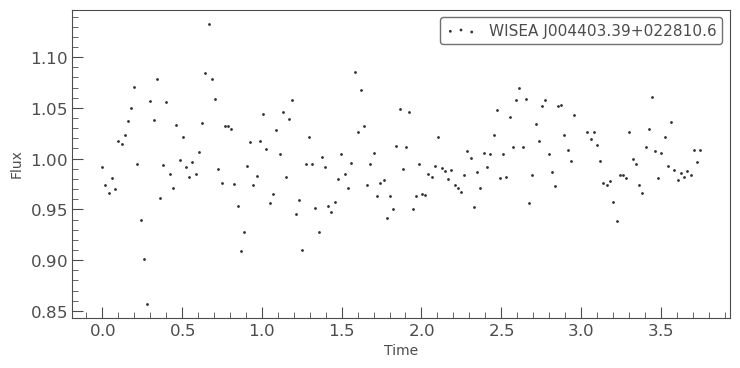

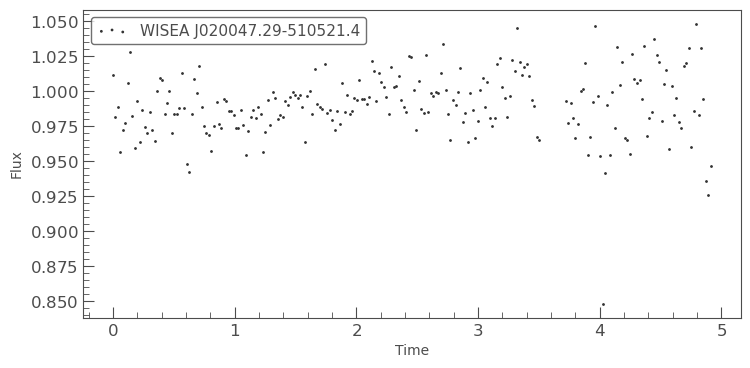

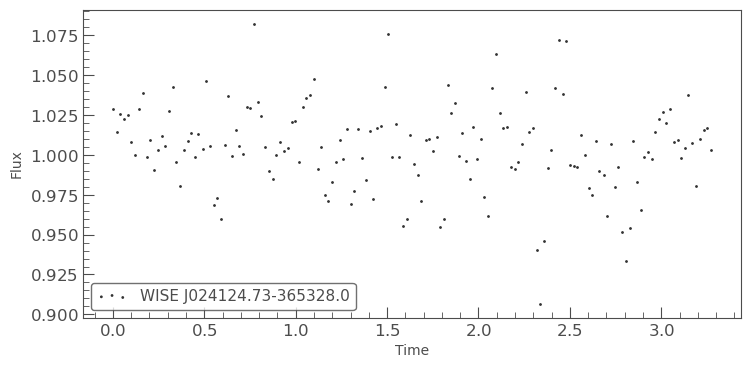

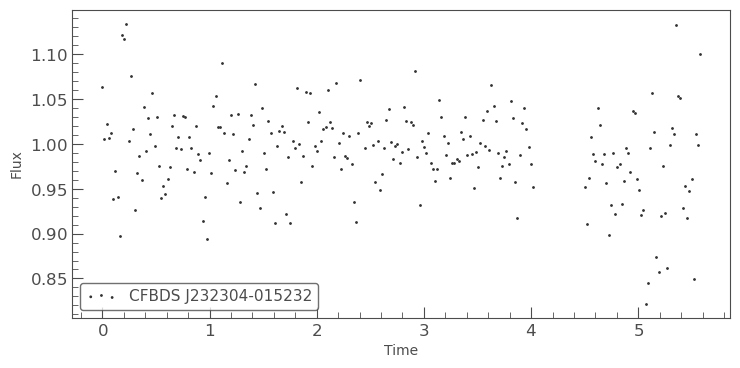

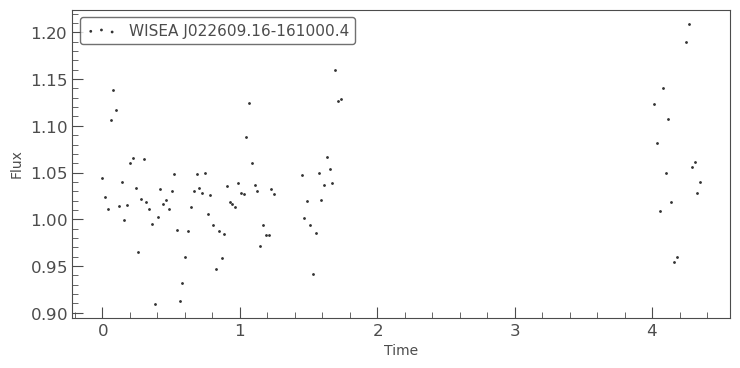

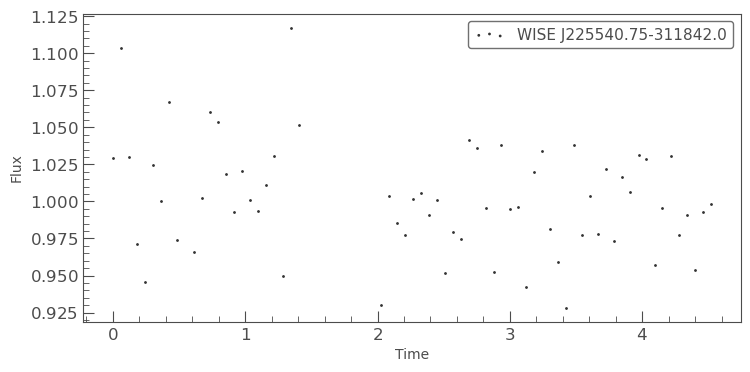

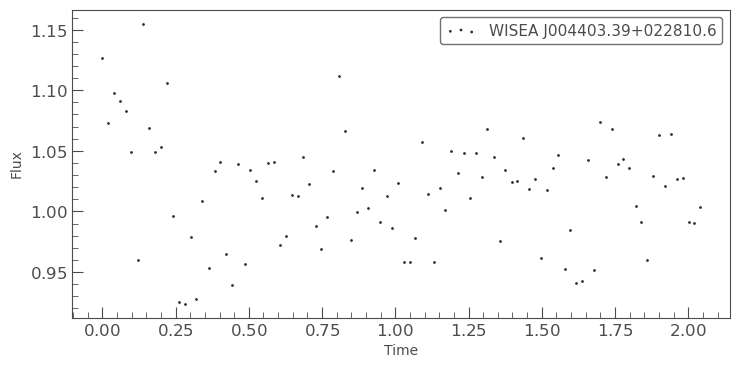

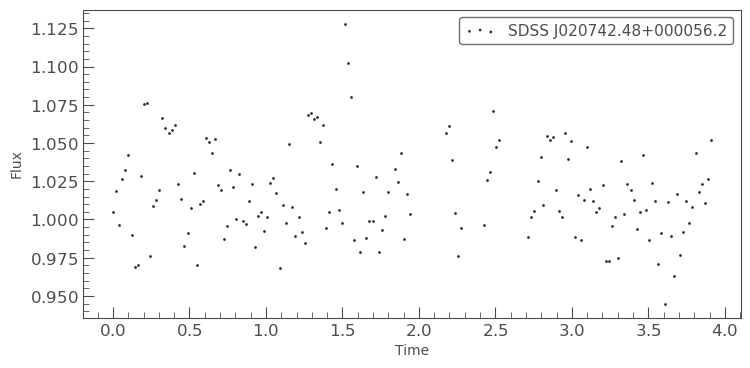

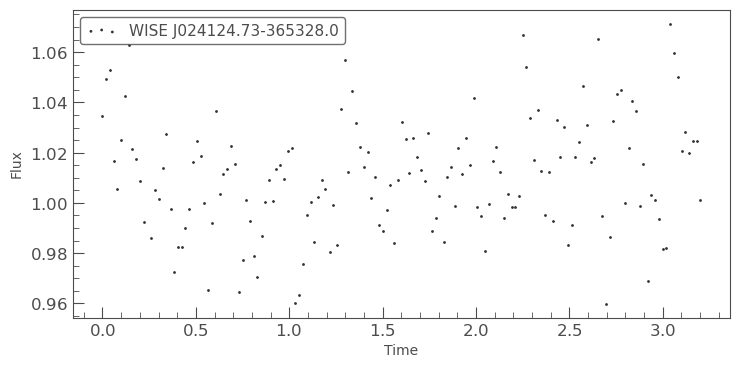

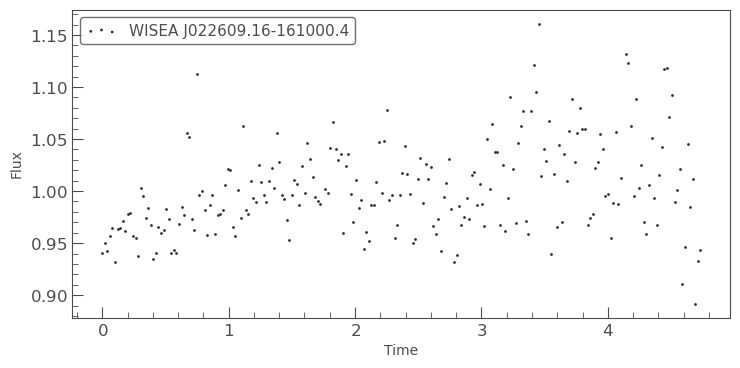

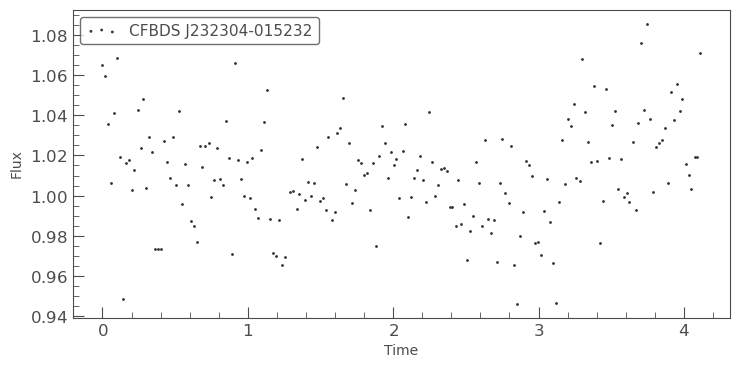

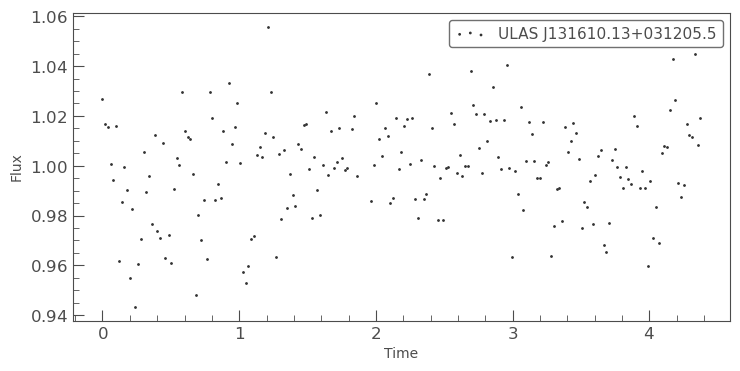

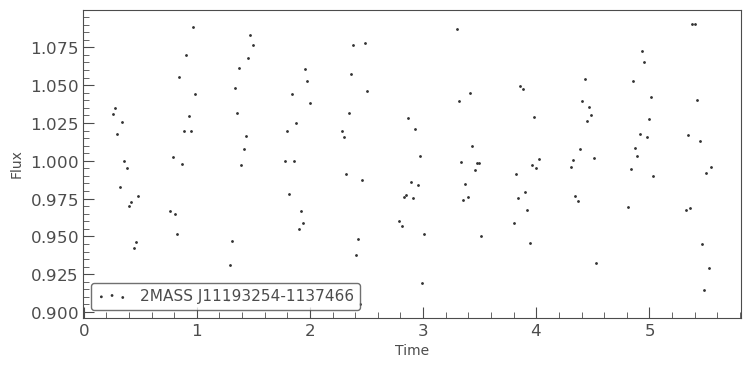

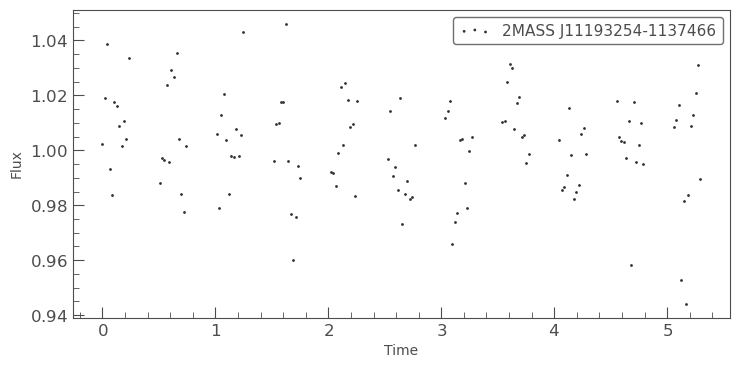

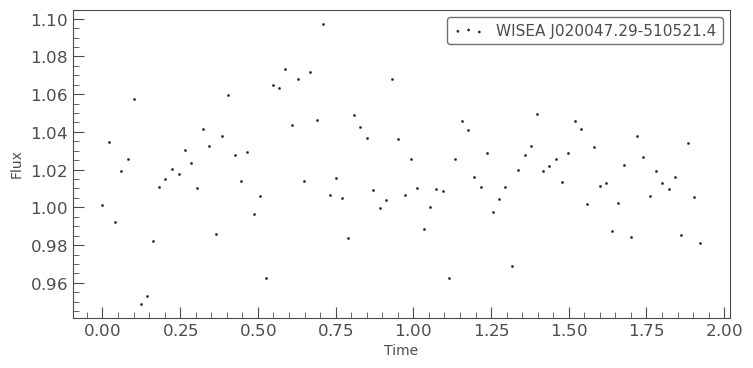

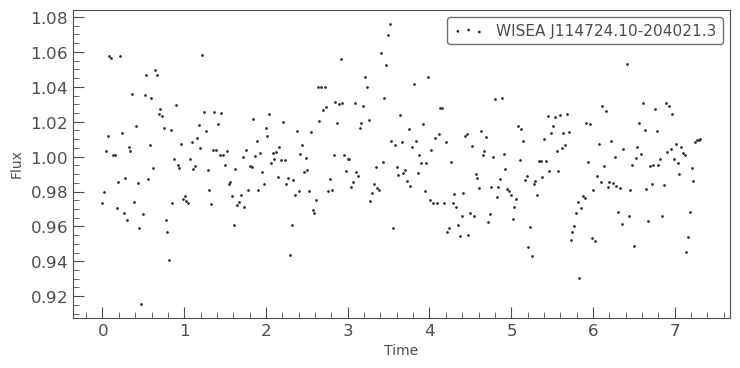

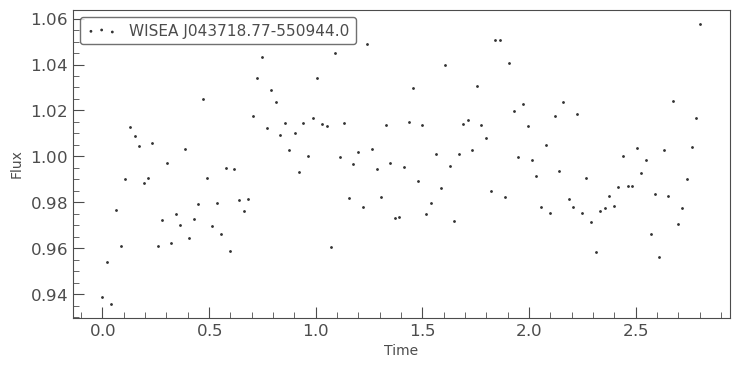

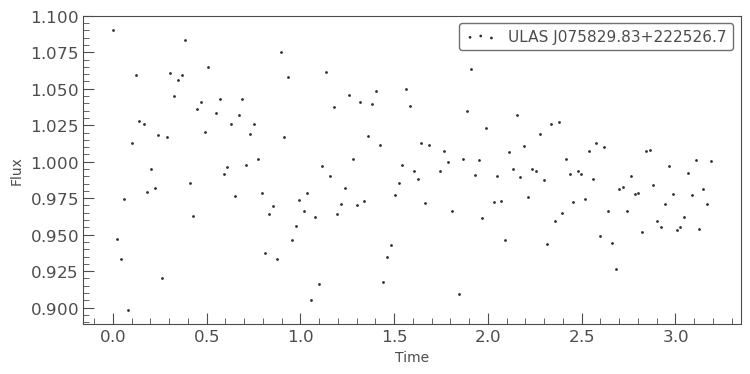

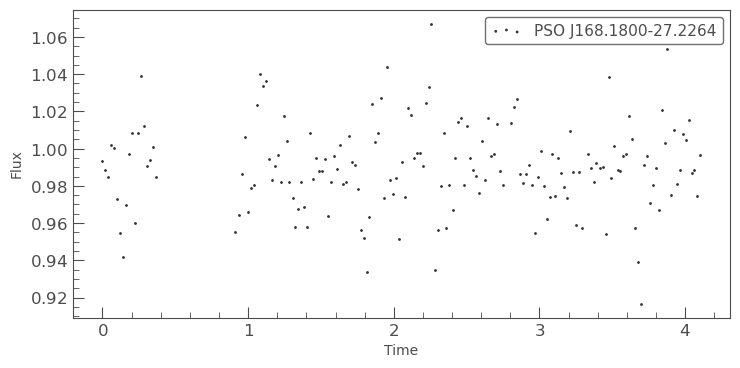

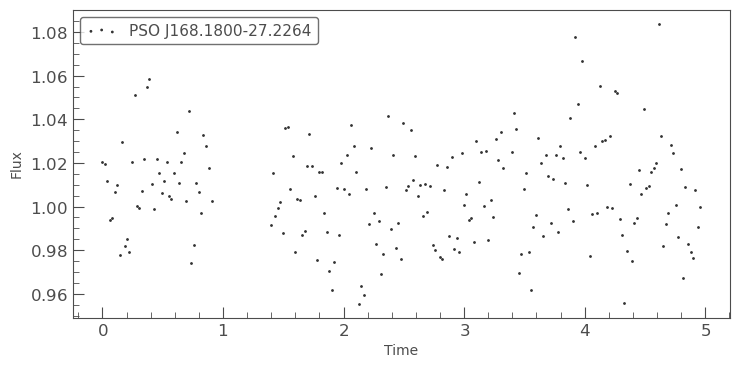

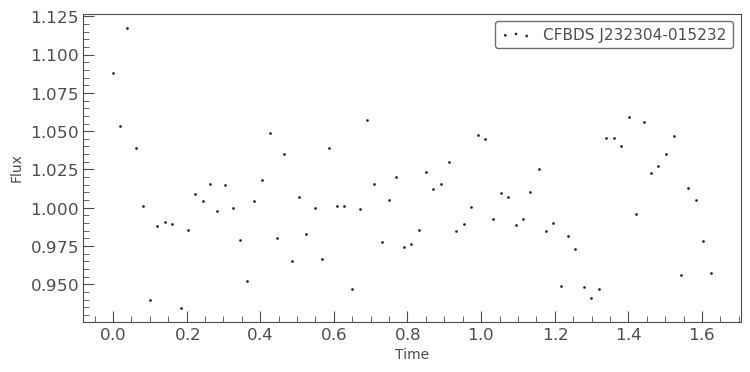

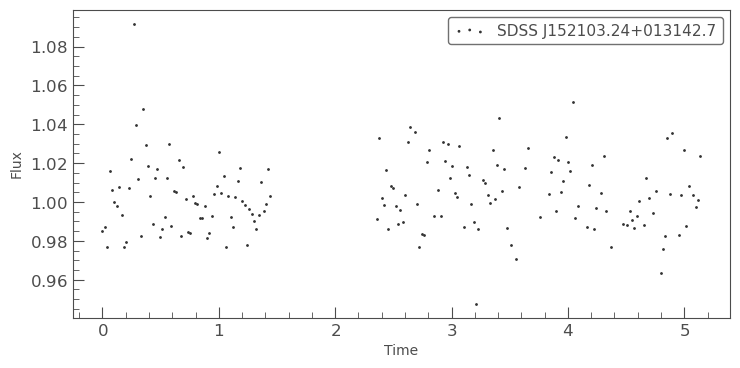

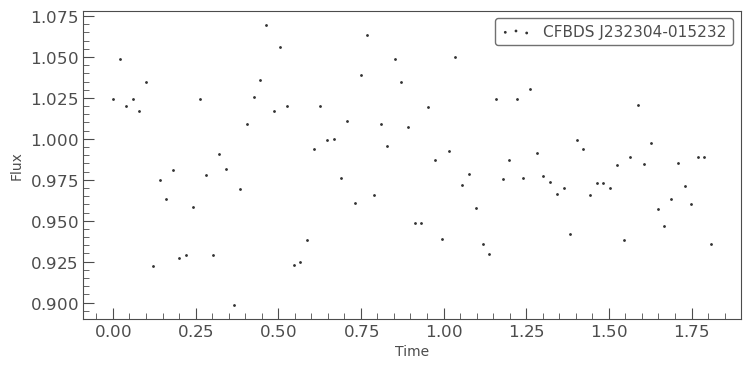

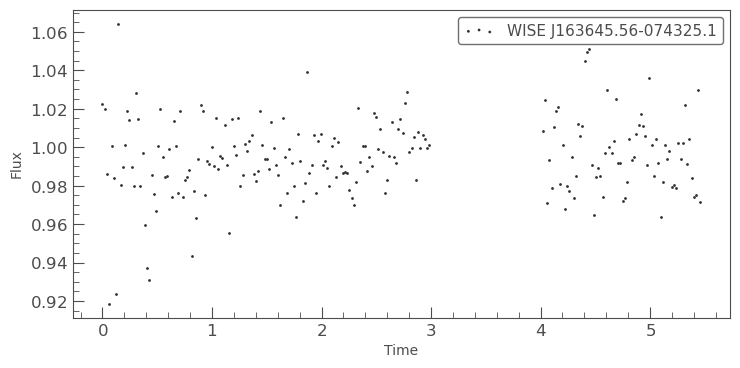

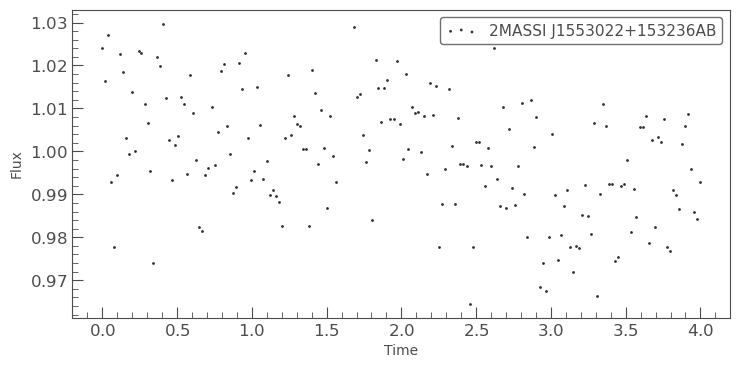

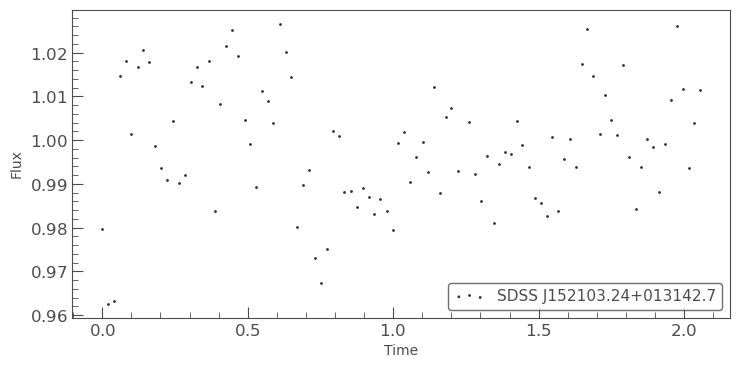

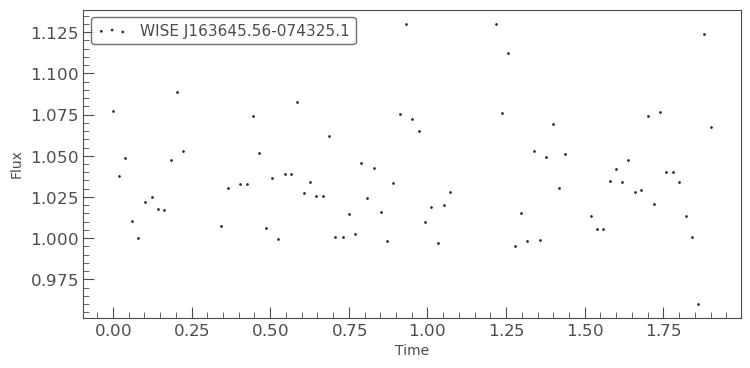

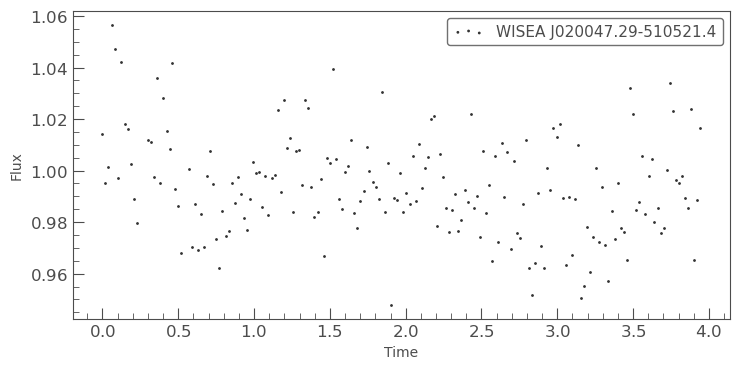

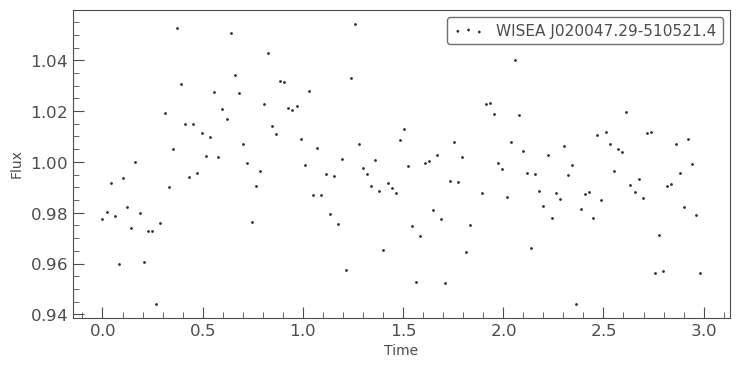

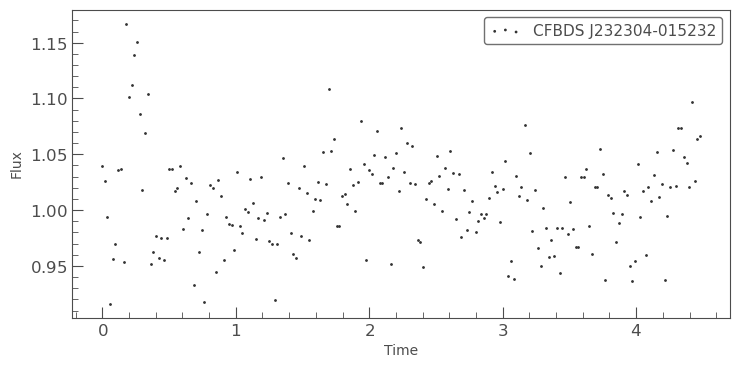

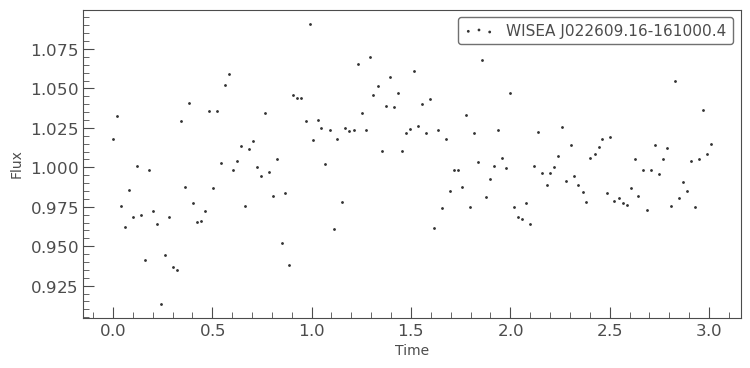

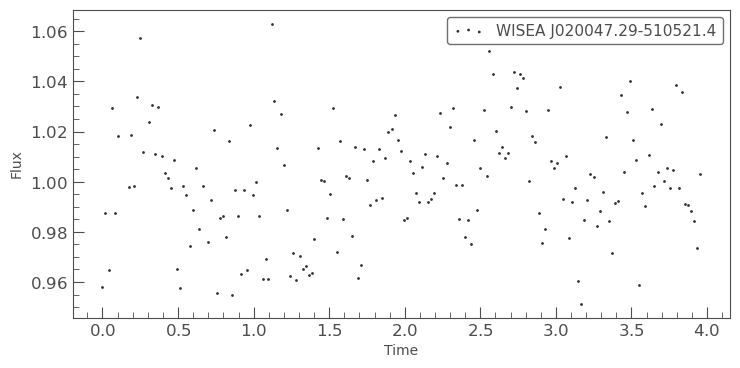

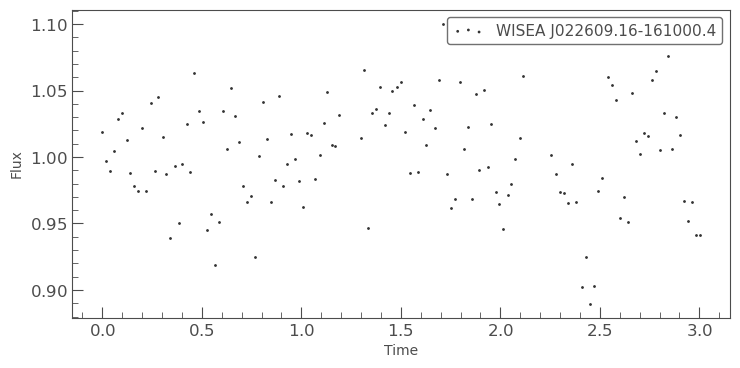

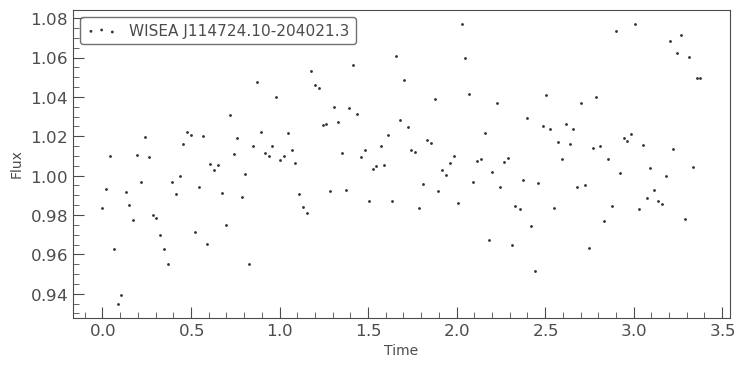

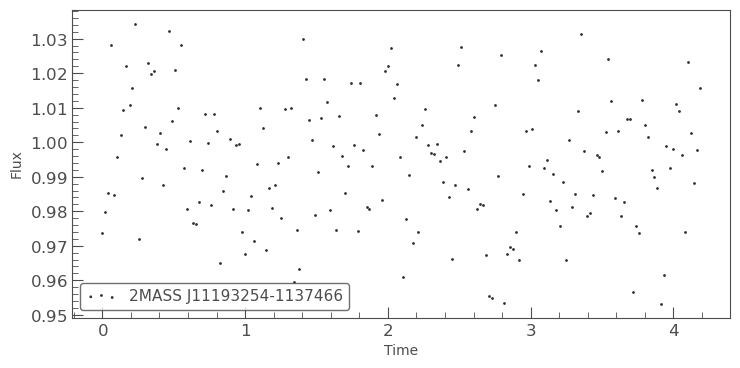

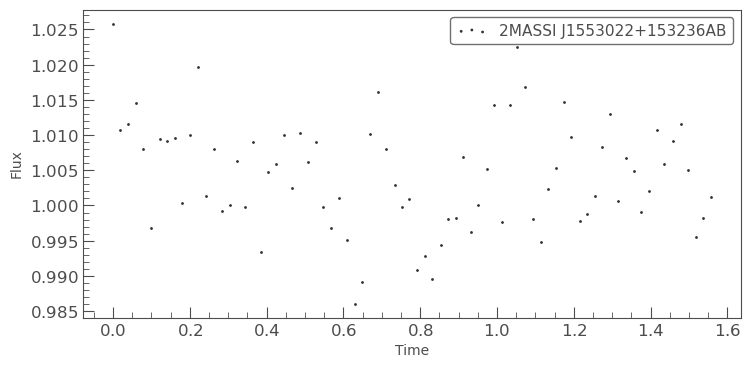

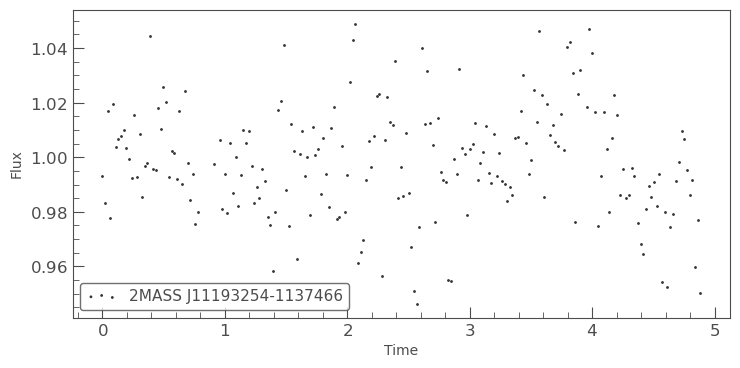

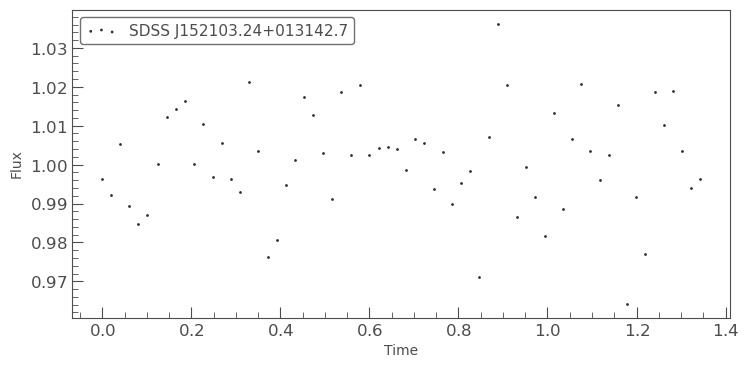

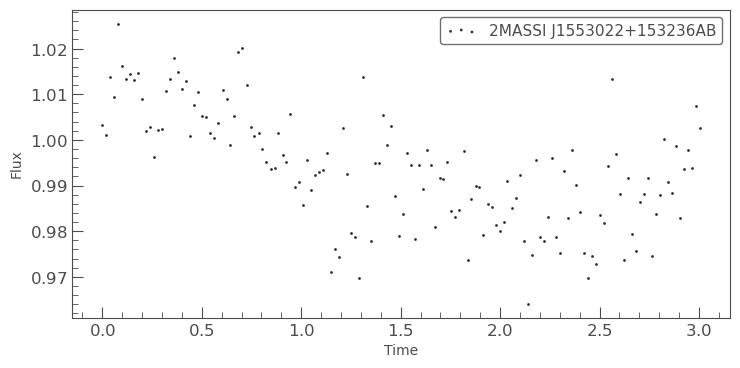

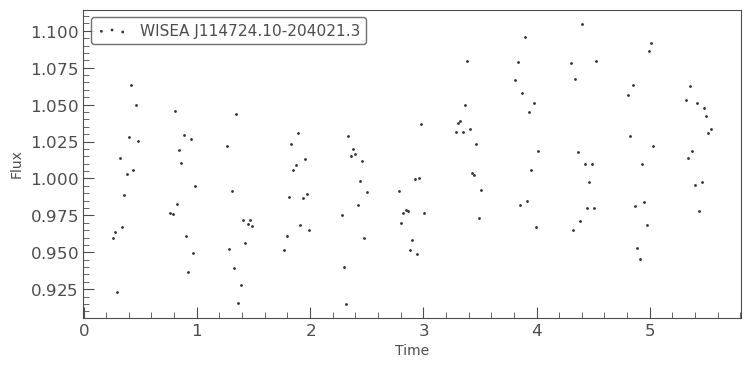

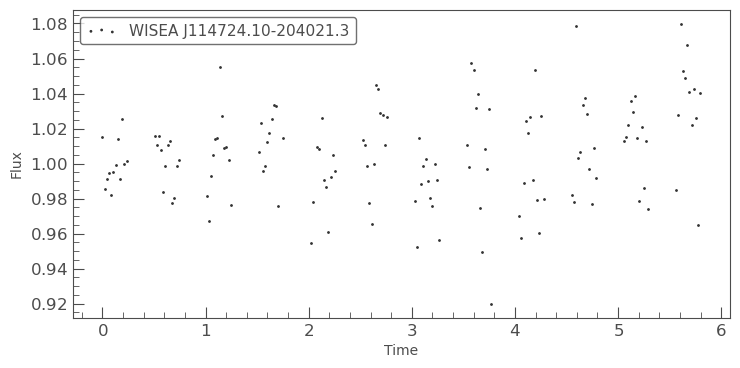

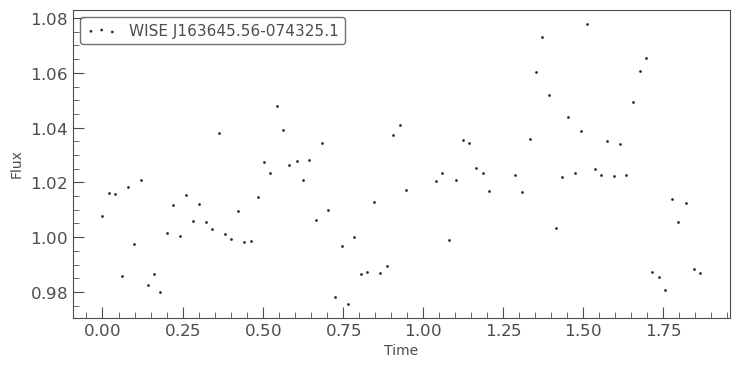

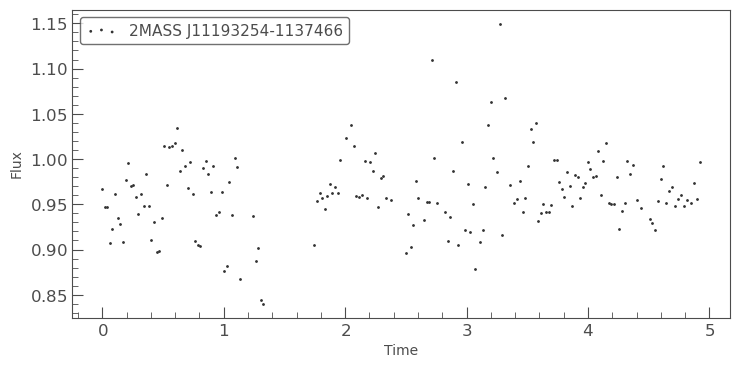

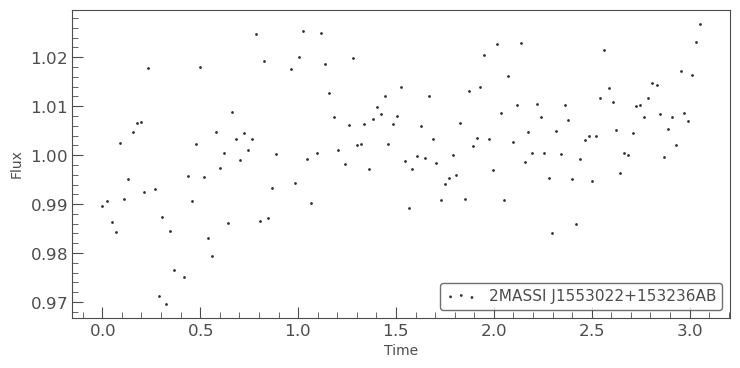

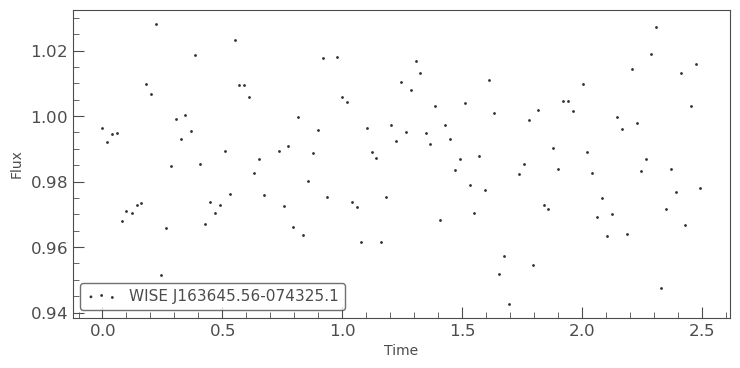

In [30]:
for i in name_files:
    lc = read_generic_lightcurve(i, time_format = 'mjd')
    lc.scatter()